In [1]:
# initialising the llm
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o",api_key=os.environ["OPENAI_API_KEY"])
result = llm.invoke("what is capital of india")
print(result)

content='The capital of India is New Delhi.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 12, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bx5wSXExLn0YASeIN2xE0zndq7i0r', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--f5c53951-8cbf-4ede-88d7-e36f6b34d1b5-0' usage_metadata={'input_tokens': 12, 'output_tokens': 8, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [2]:
def multiply(a : int , b : int):
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a : int , b : int ) -> int :
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a : int, b : int ) -> int:
    """divides a and b.

    Args:
        a: first int
        b: second int
    """
    return a-b

tools = [add,multiply, divide]
tools


[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int)>,
 <function __main__.divide(a: int, b: int) -> int>]

In [3]:
llm_with_tools = llm.bind_tools(tools)

In [4]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

# class MessageState(TypedDict):
#     messages: Annotated[list[AnyMessage],add_messages]

In [48]:
from langchain_core.messages import HumanMessage,SystemMessage
sys_msg = SystemMessage(content="you are a help ful assitant who will do arithematic operations")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]} 

In [49]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("assistant",assistant)
graph_builder.add_node(ToolNode(tools=tools))


In [50]:
from langgraph.checkpoint.memory import MemorySaver
memory =  MemorySaver()

graph_builder.add_edge(START,"assistant")
graph_builder.add_conditional_edges("assistant",tools_condition)
graph_builder.add_edge("tools","assistant")

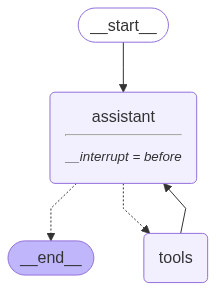

In [51]:
from IPython.display import Image, display

graph = graph_builder.compile(interrupt_before=["assistant"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [52]:
from pprint import pprint
config = {"configurable":{"thread_id":"3"}}

for event in graph.stream(input=MessagesState(messages=[HumanMessage(content="what is 2 plus 2")],),config = config,stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='12e1a92c-64f4-4945-a11a-3d845e4df98c')]}


In [53]:
#most recent state
state = graph.get_state(config=config)


In [59]:
#next state
state.next

#list of all states
for event in graph.get_state_history(config):
    print(event)

print(state.values)
state.parent_config


StateSnapshot(values={'messages': [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='12e1a92c-64f4-4945-a11a-3d845e4df98c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KOirwuFZUB6aDsN9fMoWxYBN', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 133, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bx66vA4sUgjjtpbQrPsmt6ja1iXdh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a23750f9-961e-4e0a-8755-e2f77fb3fa04-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_KOirwuFZUB6aDsN9f

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0691fc-8969-60e4-8002-866cf28719fa'}}

In [56]:
for event in graph.stream(None,config,stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='12e1a92c-64f4-4945-a11a-3d845e4df98c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KOirwuFZUB6aDsN9fMoWxYBN', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 133, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bx66vA4sUgjjtpbQrPsmt6ja1iXdh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a23750f9-961e-4e0a-8755-e2f77fb3fa04-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_KOirwuFZUB6aDsN9fMoWxYBN', 'type': 'to

In [58]:
state = graph.get_state(config=config)
state.next

()

In [62]:
graph.update_state(config,None)

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f069248-2ff7-6c9c-8005-5f73392bd3eb'}}